In [1]:
# Struktur des Dokumentes ist angelehnt an Evluation Jupyter Notebook von Marcel Niehüsener:
# https://git.fh-muenster.de/lv-grewe/mwi/fep/fep22/rust/rust-go-concurrency-comparison/measurements/-/blob/main/evaluation/evaluation.ipynb

import glob
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

pd.set_option("display.max_columns", None)
plt.style.use('ggplot')

data_path = r'C:/Users/afarwick/Documents/Studium/SS22/netzwerkrichtlinien-messungen/ergebnisse/2022-07-09/'
file_list = glob.glob(data_path+'*.json')

dataframes = []
for file in file_list:
    with open(file) as f:
        fortio_json = json.load(f)
        fortio_data = pd.json_normalize(fortio_json)
        mem_data = pd.read_csv(file.replace('.json', '-top-mem.txt'), sep=",", header=None)
        mem_data = mem_data.drop([3], axis=1)
        mem_data.columns = ["total", "free", "used"]       
        cpu_data = pd.read_csv(file.replace('.json', '-top-cpu.txt'), sep=",", header=None)
        cpu_data = cpu_data.drop([2, 4, 5, 7], axis=1)
        cpu_data.columns = ["us", "sy", "id", "si"]
        mem_data["total"] = mem_data["total"].astype("float64")
        mem_data["free"] = mem_data["free"].astype("float64")
        mem_data["used"] = mem_data["used"].astype("float64")
        cpu_data["us"] = cpu_data["us"].astype("float64")
        cpu_data["sy"] = cpu_data["sy"].astype("float64")
        cpu_data["id"] = cpu_data["id"].astype("float64")
        cpu_data["si"] = cpu_data["si"].astype("float64")
        frame = pd.concat([fortio_data], axis=1)
        frame['AvgTotalMem'] = mem_data["total"].mean()
        frame['AvgFreeMem'] = mem_data["free"].mean()
        frame['AvgUsedMem'] = mem_data["used"].mean()
        frame['AvgCpuUs'] = cpu_data["us"].mean()
        frame['AvgCpuSy'] = cpu_data["sy"].mean()
        frame['AvgCpuId'] = cpu_data["id"].mean()
        frame['AvgCpuSi'] = cpu_data["si"].mean()
        frame['Filename'] = file
        filename_string = frame['Filename'].astype("string")
        frame['Labels'] = filename_string.str.split("_")
        frame['Scenario'] = frame['Labels'][0][1]
        frame['Implementation'] = frame['Labels'][0][2]
        frame['NumPolicies'] = frame['Labels'][0][6]
        frame['NumPolicies'] = frame['NumPolicies'].astype("int64")
        frame['NumPods'] = frame['Labels'][0][4]
        frame['NumPods'] = frame['NumPods'].astype("int64")
        dataframes.append(frame)

data = pd.concat(dataframes, ignore_index=True)
data['AvgDuration'] = data['DurationHistogram.Avg']
data = data.drop(data.columns.difference(['Scenario', 'Implementation', 'NumPolicies', 'NumPods', 'AvgUsedMem', 'AvgCpuUs', 'AvgCpuSy', 'AvgCpuId', 'AvgCpuSi', 'AvgDuration', 'ActualQPS']), axis=1)
print(data)

       ActualQPS   AvgUsedMem   AvgCpuUs   AvgCpuSy   AvgCpuId   AvgCpuSi  \
0   70164.578755  1002.793939  32.183333  10.639394  34.769697  22.413636   
1   68531.327265   775.775806  39.287097  13.733871  19.885484  27.096774   
2    5303.350460   874.058065  32.543548   7.629032  51.987097   7.830645   
3       3.999804  1001.001786   1.966071   0.867857  97.035714   0.089286   
4       3.999864   775.573585   2.264151   1.011321  96.569811   0.122642   
5       3.999421   868.911765   2.105882   0.813725  96.935294   0.117647   
6   51363.819422  1157.914286  30.122222  13.634921  35.682540  20.577778   
7   45161.503709  1241.350769  29.949231  15.649231  34.616923  19.806154   
8   69426.110456  1001.428125  32.446875  10.821875  33.884375  22.848438   
9   36010.472295  1324.292308  29.112308  17.609231  35.915385  17.367692   
10  39242.500906  1398.901515  29.230303  16.825758  35.396970  18.530303   
11  37802.853543  1475.388060  28.601493  16.794030  37.255224  17.353731   

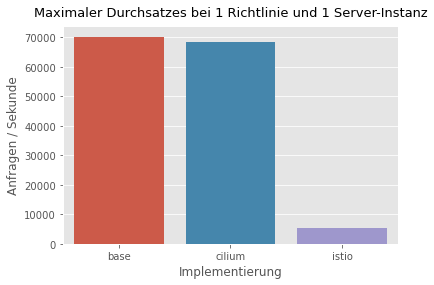

In [2]:
frame = data[(data.Scenario == 'durchsatz')]
sns.barplot(data=frame, x='Implementation', y='ActualQPS')
plt.title("Maximaler Durchsatzes bei 1 Richtlinie und 1 Server-Instanz", fontsize=13, pad=10.0)
plt.ylabel('Anfragen / Sekunde')
plt.xlabel('Implementierung')
plt.show()

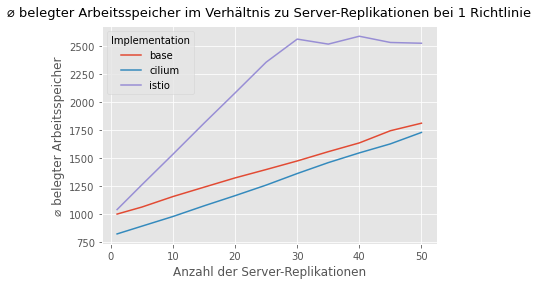

In [3]:
frame = data[(data.Scenario == 'pod-skalierbarkeit')]
sns.lineplot(data=frame,x='NumPods', y='AvgUsedMem', hue='Implementation')
plt.title("⌀ belegter Arbeitsspeicher im Verhältnis zu Server-Replikationen bei 1 Richtlinie", fontsize=13, pad=10.0)
plt.ylabel('⌀ belegter Arbeitsspeicher')
plt.xlabel('Anzahl der Server-Replikationen')
plt.show()

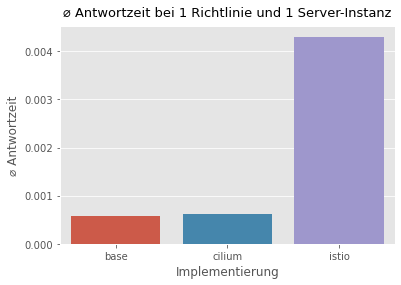

In [4]:
frame = data[(data.Scenario == 'latenz')]
sns.barplot(data=frame, x='Implementation', y='AvgDuration')
plt.title("⌀ Antwortzeit bei 1 Richtlinie und 1 Server-Instanz", fontsize=13, pad=10.0)
plt.ylabel('⌀ Antwortzeit')
plt.xlabel('Implementierung')
plt.show()

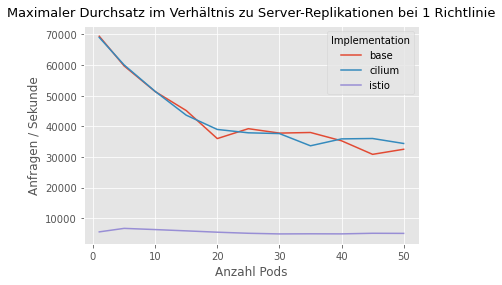

In [5]:
frame = data[(data.Scenario == 'pod-skalierbarkeit')]
sns.lineplot(data=frame, x='NumPods', y='ActualQPS', hue='Implementation')
plt.title("Maximaler Durchsatz im Verhältnis zu Server-Replikationen bei 1 Richtlinie", fontsize=13, pad=10.0)
plt.ylabel('Anfragen / Sekunde')
plt.xlabel('Anzahl Pods')
plt.show()

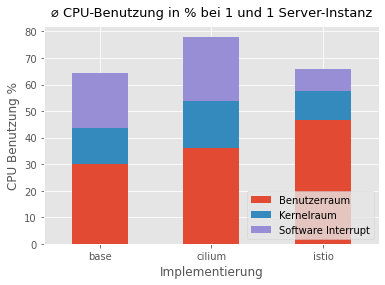

In [6]:
frame = data[(data.Scenario == 'pod-skalierbarkeit') & (data.NumPods == 10)]
frame = frame.drop(data.columns.difference(['Implementation', 'AvgCpuUs', 'AvgCpuSy', 'AvgCpuSi']), axis=1)
frame = frame.rename(columns = {'AvgCpuUs':'Benutzerraum', 'AvgCpuSy':'Kernelraum', 'AvgCpuSi':'Software Interrupt' })
frame = frame[['Implementation', 'Benutzerraum','Kernelraum','Software Interrupt']]


frame.set_index('Implementation').plot( kind='bar', stacked=True, rot=0)
plt.legend(loc='lower right')
plt.title("⌀ CPU-Benutzung in % bei 1 und 1 Server-Instanz", fontsize=13, pad=10.0)
plt.ylabel('CPU Benutzung %')
plt.xlabel('Implementierung')

# show the graph
plt.show()